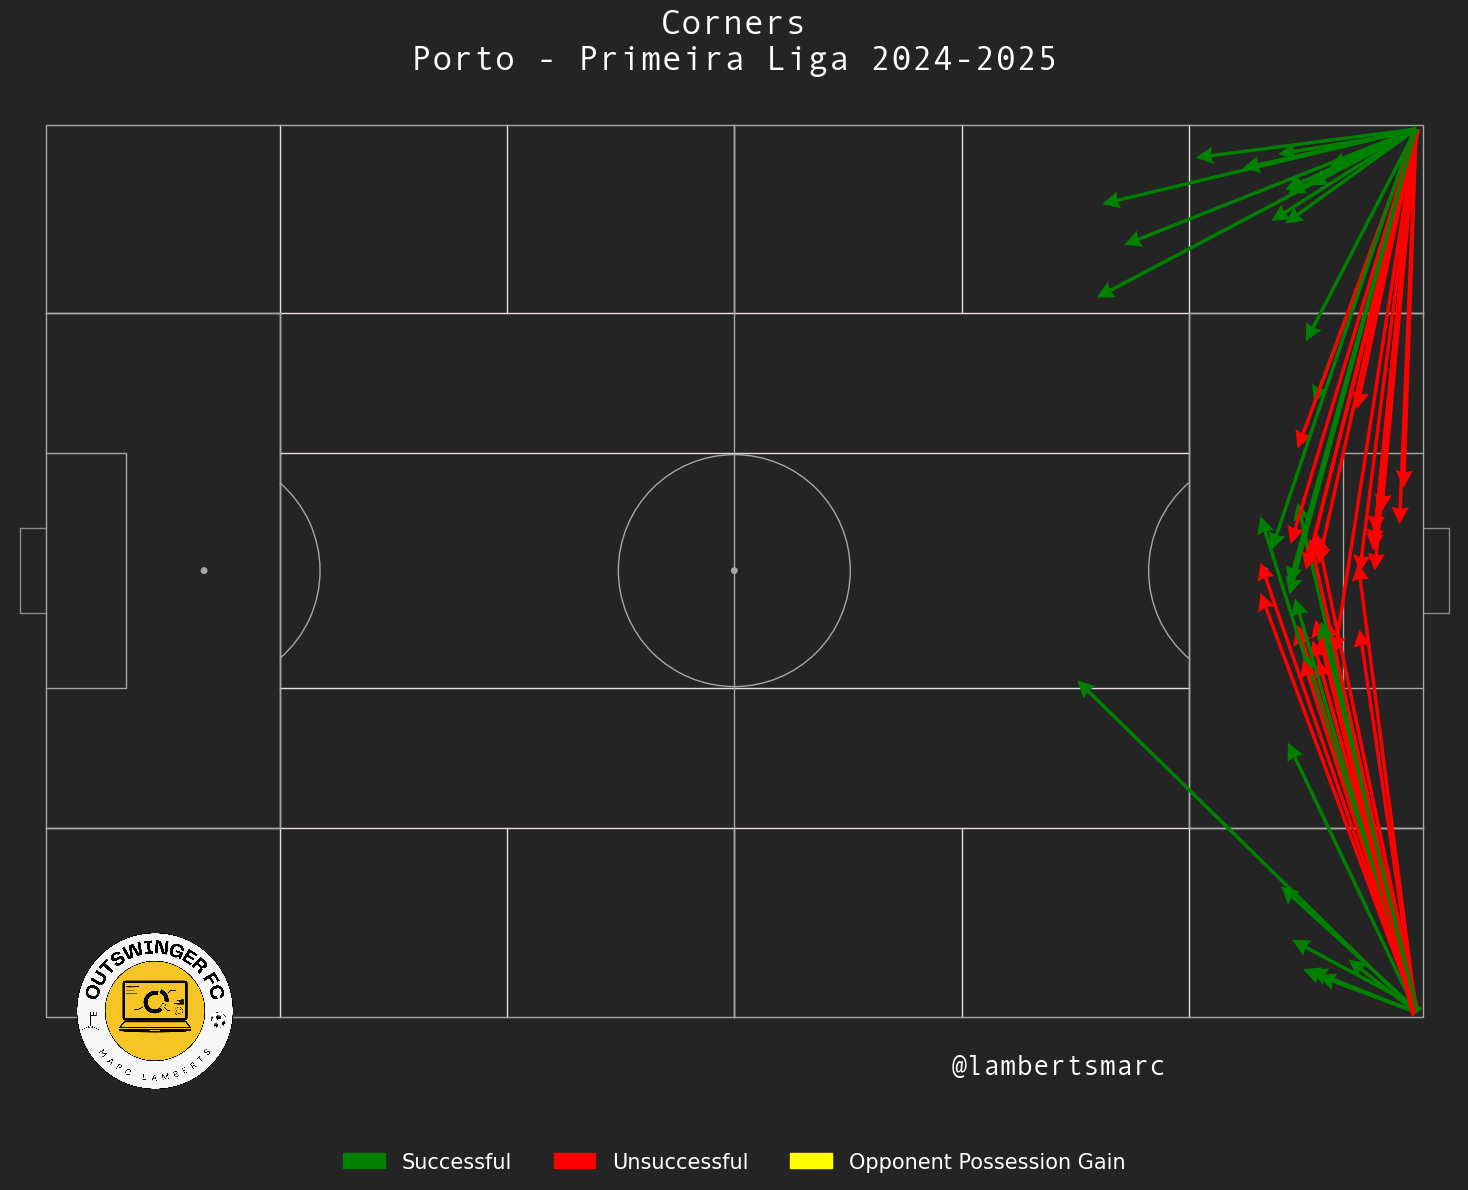

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as patches

# Load data
df = pd.read_excel("xT.xlsx")
# Filter for the specified team and reset the index
df = df.loc[(df['contestantId'] == '66bsnl0zjb7l5akwo00h0y5me')].reset_index()

# Set up pitch
pitch = Pitch(positional=True, pitch_type='opta', pad_bottom=0.5, pad_top=5,
              pitch_color='#242424', line_color='#a6a6a6', linewidth=1, half=False, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw(figsize=(18, 12))

# Track where the opposing team gains possession within the next two actions after a corner
possession_changes = []
for i, row in df.iterrows():
    # Identify if the event is a corner
    if row['Corner'] == 1:
        # Get the next two actions
        next_two_actions = df.iloc[i+1:i+3]
        
        # Check if the opposing team gains possession within these actions
        for _, action in next_two_actions.iterrows():
            if action['contestantId'] != row['contestantId']:  # Possession changes to the opponent
                possession_changes.append(action)  # Record this possession change
                break  # Stop after the first possession gain within the two actions

# Plot the corners
for i, x in enumerate(df['x']):
    if df['outcome'].iloc[i] == 1 and df['Corner'].iloc[i] == True:
        end_x = df['endX'].iloc[i]
        end_y = df['endY'].iloc[i]
        pitch.arrows(df['x'].iloc[i], df['y'].iloc[i], end_x, end_y, 
                     width=2.5, zorder=2, headwidth=5, headlength=5, color='green', ax=ax)
    elif df['outcome'].iloc[i] == 0 and df['Corner'].iloc[i] == True:
        end_x = df['endX'].iloc[i]
        end_y = df['endY'].iloc[i]
        pitch.arrows(df['x'].iloc[i], df['y'].iloc[i], end_x, end_y, 
                     width=2.5, zorder=2, headwidth=5, headlength=5, color='red', ax=ax)

# Plot possession gains by the opponent within two actions of a corner
for change in possession_changes:
    pitch.scatter(change['x'], change['y'], color='yellow', edgecolor='black', s=200, marker='X', ax=ax, zorder=3)

# Add a logo in the bottom left corner
logo = plt.imread("/Users/marclambertes/Downloads/Outswinger FC (3).png")
imagebox = OffsetImage(logo, zoom=0.09)
ab = AnnotationBbox(imagebox, (0.1, 0.01), frameon=False, xycoords='figure fraction', boxcoords="axes fraction")
ax.add_artist(ab)

# Set face color and title
fig.set_facecolor('#242424')
ax.set_title("Corners\nPorto - Primeira Liga 2024-2025", fontsize=25, color="w", fontfamily="Andale Mono", fontweight='bold', pad=8)

# Add legend
colors = {'Successful': 'green', 'Unsuccessful': 'red', 'Possession Gain': 'yellow'}
labels = {'Successful': 'Successful', 'Unsuccessful': 'Unsuccessful', 'Possession Gain': 'Opponent Possession Gain'}

ax.legend(handles=[patches.Patch(color=color) for color in colors.values()],
          labels=labels.values(), labelcolor='w', loc='lower center', bbox_to_anchor=(0.5, -0.18),
          ncol=3, frameon=False, fontsize=15)

# Add text
fig.text(.62, 0.1, '@lambertsmarc', fontstyle='italic', fontsize=20, fontfamily="Andale Mono", color='white')

# Save figure
plt.savefig('Benfica_Corners_with_Possession_Gains.png', dpi=500, bbox_inches='tight', facecolor='#242424')
plt.show()


In [24]:
import pandas as pd

# Load data
df = pd.read_excel("Portopass.xlsx")

# Filter for the specified team and reset the index
df_filtered = df.loc[df['contestantId'] == '66bsnl0zjb7l5akwo00h0y5me'].reset_index(drop=True)

# Combine `timeMin` and `timeSec` into a single timestamp (in seconds)
df_filtered['timestamp'] = df_filtered['timeMin'] * 60 + df_filtered['timeSec']

# Sort the data by timestamp to ensure chronological order
df_filtered = df_filtered.sort_values(by='timestamp').reset_index(drop=True)

# Add shifted columns for the next ten actions
for action_num in range(1, 11):
    df_filtered[f'next_action_{action_num}_eventId'] = df_filtered['eventId'].shift(-action_num)
    df_filtered[f'next_action_{action_num}_typeId'] = df_filtered['typeId'].shift(-action_num)

# Track the relevant data for corners with possession change information
corner_follow_ups = []
for i, row in df_filtered.iterrows():
    if row.get('Corner') == 1:  # Only check for Corner = 1
        possession_change = {}
        for action_num in range(1, 11):  # Check the next 10 actions
            next_action_contestant = df_filtered['contestantId'].shift(-action_num).iloc[i]
            possession_change[f'PossessionChangeAction_{action_num}'] = next_action_contestant != '66bsnl0zjb7l5akwo00h0y5me'

        # Add corner and possession change data to results
        corner_follow_ups.append({
            'CornerEventId': row['eventId'],
            **{f'NextAction{action_num}EventId': row[f'next_action_{action_num}_eventId'] for action_num in range(1, 11)},
            **{f'NextAction{action_num}TypeId': row[f'next_action_{action_num}_typeId'] for action_num in range(1, 11)},
            **possession_change
        })

# Create a DataFrame for the results
corner_follow_ups_df = pd.DataFrame(corner_follow_ups)

# Export the results to an Excel file
output_file_path_timestamp = "corner_with_next_10_actions_possession_changes_no_xy.xlsx"
corner_follow_ups_df.to_excel(output_file_path_timestamp, index=False)

output_file_path_timestamp


'corner_with_next_10_actions_possession_changes_no_xy.xlsx'

In [17]:
# Add shifted columns for the next four actions
df_filtered['next_action_1_eventId'] = df_filtered['eventId'].shift(-1)
df_filtered['next_action_1_typeId'] = df_filtered['typeId'].shift(-1)
df_filtered['next_action_1_x'] = df_filtered['x'].shift(-1)
df_filtered['next_action_1_y'] = df_filtered['y'].shift(-1)

df_filtered['next_action_2_eventId'] = df_filtered['eventId'].shift(-2)
df_filtered['next_action_2_typeId'] = df_filtered['typeId'].shift(-2)
df_filtered['next_action_2_x'] = df_filtered['x'].shift(-2)
df_filtered['next_action_2_y'] = df_filtered['y'].shift(-2)

df_filtered['next_action_3_eventId'] = df_filtered['eventId'].shift(-3)
df_filtered['next_action_3_typeId'] = df_filtered['typeId'].shift(-3)
df_filtered['next_action_3_x'] = df_filtered['x'].shift(-3)
df_filtered['next_action_3_y'] = df_filtered['y'].shift(-3)

df_filtered['next_action_4_eventId'] = df_filtered['eventId'].shift(-4)
df_filtered['next_action_4_typeId'] = df_filtered['typeId'].shift(-4)
df_filtered['next_action_4_x'] = df_filtered['x'].shift(-4)
df_filtered['next_action_4_y'] = df_filtered['y'].shift(-4)

# Track the relevant data for corners with possession change information
corner_follow_ups = []
for i, row in df_filtered.iterrows():
    if row.get('Corner') == 1:  # Only check for Corner = 1
        possession_change = {}
        for action_num in range(1, 5):  # Check the next 4 actions
            next_action_contestant = df_filtered['contestantId'].shift(-action_num).iloc[i]
            if next_action_contestant != '66bsnl0zjb7l5akwo00h0y5me':
                possession_change[f'PossessionChangeAction_{action_num}'] = True
                possession_change[f'PossessionChangeAction_{action_num}_x'] = df_filtered['x'].shift(-action_num).iloc[i]
                possession_change[f'PossessionChangeAction_{action_num}_y'] = df_filtered['y'].shift(-action_num).iloc[i]
            else:
                possession_change[f'PossessionChangeAction_{action_num}'] = False
                possession_change[f'PossessionChangeAction_{action_num}_x'] = None
                possession_change[f'PossessionChangeAction_{action_num}_y'] = None

        # Add corner and possession change data to results
        corner_follow_ups.append({
            'CornerEventId': row['eventId'],
            'NextAction1EventId': row['next_action_1_eventId'],
            'NextAction1TypeId': row['next_action_1_typeId'],
            'NextAction1_x': row['next_action_1_x'],
            'NextAction1_y': row['next_action_1_y'],
            'NextAction2EventId': row['next_action_2_eventId'],
            'NextAction2TypeId': row['next_action_2_typeId'],
            'NextAction2_x': row['next_action_2_x'],
            'NextAction2_y': row['next_action_2_y'],
            'NextAction3EventId': row['next_action_3_eventId'],
            'NextAction3TypeId': row['next_action_3_typeId'],
            'NextAction3_x': row['next_action_3_x'],
            'NextAction3_y': row['next_action_3_y'],
            'NextAction4EventId': row['next_action_4_eventId'],
            'NextAction4TypeId': row['next_action_4_typeId'],
            'NextAction4_x': row['next_action_4_x'],
            'NextAction4_y': row['next_action_4_y'],
            **possession_change
        })

# Create a DataFrame for the results
corner_follow_ups_df = pd.DataFrame(corner_follow_ups)

# Export the results to an Excel file
output_file_path_timestamp = "corner_with_next_4_actions_possession_changes_with_xy.xlsx"
corner_follow_ups_df.to_excel(output_file_path_timestamp, index=False)

output_file_path_timestamp


'corner_with_next_4_actions_possession_changes_with_xy.xlsx'